In [1]:
import pandas as pd
import os


In [2]:
# Define file paths
data_dir = "./data"
file_sentiment_googleNLP = os.path.join(
    data_dir, "survey_clean_stemmed_sentiment_googleNLP.csv"
)
file_sentiment_indoBERT = os.path.join(
    data_dir, "survey_clean_stemmed_sentiment_indoBERT.csv"
)
file_output = os.path.join(data_dir, "sentiment.csv")


def label_sentiment(score):
    if pd.isnull(score):
        return score
    elif score > 0.4:
        return 1
    elif score < -0.4:
        return -1
    else:
        return 0


# Check if the files exist
if not os.path.exists(file_sentiment_googleNLP):
    print(f"File not found: {file_sentiment_googleNLP}")
elif not os.path.exists(file_sentiment_indoBERT):
    print(f"File not found: {file_sentiment_indoBERT}")
else:
    print("Files found. You can proceed.")
try:
    # Read in the data
    sentiment_googleNLP = pd.read_csv(file_sentiment_googleNLP)
    sentiment_indoBERT = pd.read_csv(file_sentiment_indoBERT)

    # Select only the columns we need
    sentiment_googleNLP = sentiment_googleNLP[
        ["stemmed_message", "sentiment_score", "sentiment_label"]
    ]
    sentiment_indoBERT = sentiment_indoBERT[
        ["stemmed_message", "sentiment_score", "sentiment"]
    ]

    # Rename the columns for clarity
    sentiment_googleNLP.rename(
        columns={
            "stemmed_message": "text_stemmed",
            "sentiment_score": "sentiment_score_googleNLP",
            "sentiment_label": "sentiment_googleNLP",
        },
        inplace=True,
    )
    sentiment_indoBERT.rename(
        columns={
            "stemmed_message": "text_stemmed",
            "sentiment_score": "sentiment_score_indoBERT",
            "sentiment": "sentiment_indoBERT",
        },
        inplace=True,
    )

    # Drop rows with missing values in both dataframes
    sentiment_googleNLP.dropna(inplace=True)
    sentiment_indoBERT.dropna(inplace=True)

    # Get the intersection of the indices of the two dataframes
    common_indices = sentiment_googleNLP.index.intersection(sentiment_indoBERT.index)

    # Select only the rows with common indices in both dataframes
    sentiment_googleNLP = sentiment_googleNLP.loc[common_indices]
    sentiment_indoBERT = sentiment_indoBERT.loc[common_indices]

    # Merge the two dataframes based on the index
    sentiment = pd.merge(
        sentiment_googleNLP, sentiment_indoBERT, left_index=True, right_index=True
    )

    if isinstance(sentiment["sentiment_googleNLP"], pd.Series):
        sentiment["sentiment_googleNLP"] = sentiment["sentiment_googleNLP"].map(
            {"positive": 1, "neutral": 0, "negative": -1}
        )
    else:
        print("sentiment['sentiment_googleNLP'] is not a Series")

    sentiment["sentiment_score_googleNLP"] = sentiment[
        "sentiment_score_googleNLP"
    ].apply(label_sentiment)

    if isinstance(sentiment["sentiment_indoBERT"], pd.Series):
        sentiment["sentiment_indoBERT"] = sentiment["sentiment_indoBERT"].map(
            {"positive": 1, "neutral": 0, "negative": -1}
        )
    else:
        print("sentiment['sentiment_indoBERT'] is not a Series")

    # Save the new dataframe to a new file
    sentiment.to_csv(file_output, index=False)
    print("File saved successfully.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


Files found. You can proceed.
File saved successfully.


Unique labels in result_indoBERT: [-1  0  1]
Unique labels in result_googleNLP: [ 0  1 -1]


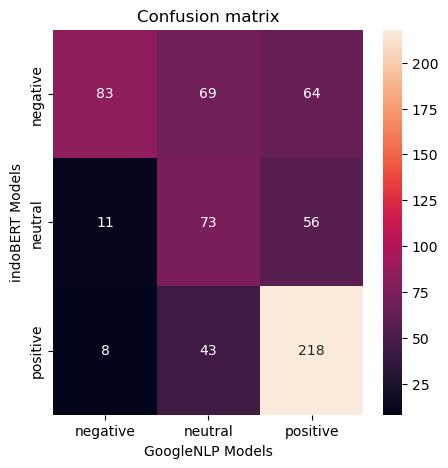

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import numpy as np

def check_columns(df, columns):
    """Check if the necessary columns exist in the DataFrame."""
    return all(column in df.columns for column in columns)


def check_labels(result_indoBERT, result_googleNLP, label_mapping):
    """Check if the labels in result_indoBERT and result_googleNLP are in the label_mapping."""
    return set(result_indoBERT.unique()).issubset(label_mapping.keys()) and set(
        result_googleNLP.unique()
    ).issubset(label_mapping.keys())


def plot_confusion_matrix(y_true_decoded, result_googleNLP_decoded, labels):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true_decoded, result_googleNLP_decoded, labels=labels)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel("indoBERT Models")
    plt.xlabel("GoogleNLP Models")
    plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
    plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
    plt.show()


result_indoBERT = sentiment["sentiment_indoBERT"]
result_googleNLP = sentiment["sentiment_score_googleNLP"]

# Check if the necessary columns exist in the sentiment DataFrame
if not check_columns(sentiment, ["sentiment_indoBERT", "sentiment_googleNLP"]):
    print("Necessary columns not found in the sentiment DataFrame.")
else:
    print("Unique labels in result_indoBERT:", result_indoBERT.unique())
    print("Unique labels in result_googleNLP:", result_googleNLP.unique())
    label_mapping = {-1: "negative", 0: "neutral", 1: "positive"}

    # Check if the labels in result_indoBERT and result_googleNLP are in the label_mapping
    if not check_labels(result_indoBERT, result_googleNLP, label_mapping):
        print("Unexpected labels found in result_indoBERT or result_googleNLP.")
    else:
        y_true_decoded = result_indoBERT.replace(label_mapping)
        result_googleNLP_decoded = result_googleNLP.replace(label_mapping)
        plot_confusion_matrix(
            y_true_decoded, result_googleNLP_decoded, list(label_mapping.values())
        )


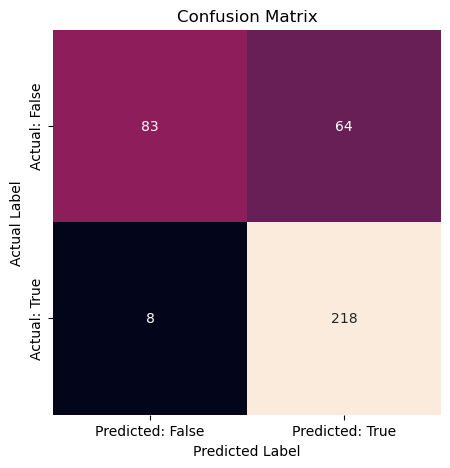

|    | Metric          | Score   |
|----|-----------------|---------|
|  0 | Global Accuracy | 80.7%   |
|  1 | Precision       | 77.3%   |
|  2 | Recall          | 96.5%   |
|  3 | F1 score        | 85.8%   |
|  4 | MCC             | 60.2%   |
|    | Error Rate   | Subset Accuracy   | Precision   |
|----|--------------|-------------------|-------------|
|  0 | 40.2%        | 59.8%             | 61.8%       |

Classification Report:

|              | precision   | recall   | f1-score   |   support |
|--------------|-------------|----------|------------|-----------|
| negative     | 81.4%       | 38.4%    | 52.2%      |  216      |
| neutral      | 39.5%       | 52.1%    | 44.9%      |  140      |
| positive     | 64.5%       | 81.0%    | 71.8%      |  269      |
| accuracy     | 59.8%       | 59.8%    | 59.8%      |    0.5984 |
| macro avg    | 61.8%       | 57.2%    | 56.3%      |  625      |
| weighted avg | 64.7%       | 59.8%    | 59.0%      |  625      |


In [7]:
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    classification_report,
)
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt


def calculate_confusion_matrix_elements(result_indoBERT, result_googleNLP):
    """Calculate elements of the confusion matrix."""
    TP = sum((result_indoBERT == 1) & (result_googleNLP == 1))
    TN = sum((result_indoBERT == -1) & (result_googleNLP == -1))
    FP = sum((result_indoBERT == -1) & (result_googleNLP == 1))
    FN = sum((result_indoBERT == 1) & (result_googleNLP == -1))
    return TP, TN, FP, FN

from matplotlib.colors import ListedColormap

def plot_confusion_matrix(TP, TN, FP, FN):
    """Plot the confusion matrix with clearer labels and a custom colormap."""
    plt.figure(figsize=(5, 5))

    # Define a custom colormap
    cmap = ListedColormap(['red', 'yellow', 'green'])

    # Create the confusion matrix
    cm = [[TN, FP], [FN, TP]]

    # Plot the heatmap
    sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=['Predicted: False', 'Predicted: True'],
                yticklabels=['Actual: False', 'Actual: True'])

    plt.title("Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()


def calculate_metrics(TP, TN, FP, FN):
    """Calculate global accuracy, precision, recall, F1 score, and MCC."""
    global_accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    mcc = (TP * TN - FP * FN) / ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
    return global_accuracy, precision, recall, f1, mcc


def tabulate_results(metrics):
    """Tabulate the results."""
    results = pd.DataFrame(
        {
            "Metric": ["Global Accuracy", "Precision", "Recall", "F1 score", "MCC"],
            "Score": ["{:.1f}%".format(metric * 100) for metric in metrics],
        }
    )
    print(tabulate(results, headers="keys", tablefmt="github"))


def calculate_error_rate(y_true_decoded, result_googleNLP_decoded):
    """Calculate error rate for the confusion matrix."""
    cm = confusion_matrix(y_true_decoded, result_googleNLP_decoded)
    error_rate = 1 - cm.diagonal().sum() / cm.sum()
    return error_rate


def calculate_accuracy_precision(result_indoBERT, result_googleNLP):
    """Calculate subset accuracy and precision."""
    subset_accuracy = accuracy_score(result_indoBERT, result_googleNLP)
    precision = precision_score(result_indoBERT, result_googleNLP, average=None)
    return subset_accuracy, precision


def tabulate_metrics(error_rate, accuracy, precision):
    """Tabulate the metrics."""
    metrics = pd.DataFrame(
        {
            "Error Rate": ["{:.1f}%".format(error_rate * 100)],
            "Subset Accuracy": ["{:.1f}%".format(accuracy * 100)],
            "Precision": ["{:.1f}%".format(precision.mean() * 100)],
        }
    )
    print(tabulate(metrics, headers="keys", tablefmt="github"))


def generate_classification_report(result_indoBERT, result_googleNLP, label_mapping):
    """Generate the classification report."""
    report = classification_report(
        result_indoBERT,
        result_googleNLP,
        target_names=label_mapping.values(),
        output_dict=True,
    )
    report_df = pd.DataFrame(report).transpose()
    report_df["precision"] = [
        "{:.1f}%".format(val * 100) for val in report_df["precision"]
    ]
    report_df["recall"] = ["{:.1f}%".format(val * 100) for val in report_df["recall"]]
    report_df["f1-score"] = [
        "{:.1f}%".format(val * 100) for val in report_df["f1-score"]
    ]
    print("\nClassification Report:\n")
    print(tabulate(report_df, headers="keys", tablefmt="github"))


# Calculate elements of the confusion matrix
TP, TN, FP, FN = calculate_confusion_matrix_elements(result_indoBERT, result_googleNLP)

# Plot the confusion matrix
plot_confusion_matrix(TP, TN, FP, FN)

# Calculate metrics
global_accuracy, precision, recall, f1, mcc = calculate_metrics(TP, TN, FP, FN)

# Tabulate the results
tabulate_results([global_accuracy, precision, recall, f1, mcc])


# Calculate error rate
error_rate = calculate_error_rate(y_true_decoded, result_googleNLP_decoded)

# Calculate accuracy and precision
subset_accuracy, precision = calculate_accuracy_precision(
    result_indoBERT, result_googleNLP
)

# Tabulate the metrics
tabulate_metrics(error_rate, subset_accuracy, precision)

# Generate the classification report
generate_classification_report(result_indoBERT, result_googleNLP, label_mapping)
